In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error


from supplemental_english import REGION_CODES, GOVERNMENT_CODES


In [9]:
df = pd.read_csv('train.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51635 entries, 0 to 51634
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      51635 non-null  int64 
 1   plate   51635 non-null  object
 2   date    51635 non-null  object
 3   price   51635 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.6+ MB


In [6]:
df.head(10)

,id,plate,date,price
0,1,X059CP797,2024-12-26 00:00:00,65000
1,2,Y800MH790,2024-07-12 21:31:37,100000
2,3,A212TX77,2024-04-18 00:00:00,290000
3,4,P001AY199,2025-01-03 00:27:15,680000
4,5,P001AY199,2025-01-10 09:32:41,750000
5,6,B400BB750,2022-04-09 00:00:00,50000
6,7,P666OM790,2024-11-14 00:00:00,300000
7,8,C080KP777,2021-06-10 12:30:00,300000
8,9,E737AY550,2024-07-31 00:00:00,60000
9,10,C001KK750,2024-07-09 08:48:39,420000


In [5]:
df["plate"].str.len().value_counts()

plate
9    36195
8    15440
Name: count, dtype: int64

In [10]:
def get_government(plate):
    num_range = int(plate[1:4])
    letters = plate[0] + plate[4:6]
    regionCodes = plate[6:]
    
    for key, value in GOVERNMENT_CODES.items():
        key_letter, (start, end), key_region = key
        if letters == key_letter and regionCodes == key_region and int(start) <= num_range <= int(end):
            return value
    return (np.nan, np.nan, np.nan, np.nan)

df[['text', 'forbidenToBuy', 'advantageOnRoad', 'significance']] = df['plate'].apply(get_government).apply(pd.Series)

df.drop("text", axis=1, inplace=True)

In [23]:
df.isnull().sum()

id                     0
plate                  0
date                   0
price                  0
forbidenToBuy      50973
advantageOnRoad    50973
significance       50973
dtype: int64

In [11]:
df.drop("id", axis=1, inplace=True)
df.fillna(0, inplace=True)

df["date"] = df["date"].astype('datetime64[ns]')
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df.drop("date", axis=1, inplace=True)

df["plate"] = df["plate"].astype('category')
df["forbidenToBuy"] = df["forbidenToBuy"].astype('int')
df["advantageOnRoad"] = df["advantageOnRoad"].astype('int')
df["significance"] = df["significance"].astype('int')
df["year"] = df["year"].astype('int')
df["month"] = df["month"].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51635 entries, 0 to 51634
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   plate            51635 non-null  category
 1   price            51635 non-null  int64   
 2   forbidenToBuy    51635 non-null  int64   
 3   advantageOnRoad  51635 non-null  int64   
 4   significance     51635 non-null  int64   
 5   year             51635 non-null  int64   
 6   month            51635 non-null  int64   
dtypes: category(1), int64(6)
memory usage: 3.9 MB


In [12]:
df

,plate,price,forbidenToBuy,advantageOnRoad,significance,year,month
0,X059CP797,65000,0,0,0,2024,12
1,Y800MH790,100000,0,0,0,2024,7
2,A212TX77,290000,0,0,0,2024,4
3,P001AY199,680000,0,0,0,2025,1
4,P001AY199,750000,0,0,0,2025,1
...,...,...,...,...,...,...,...
51630,X023PP797,70000,0,0,0,2025,1
51631,M004KA161,1600000,0,0,0,2025,1
51632,E888EB199,850000,0,0,0,2025,2
51633,X023XK77,150000,0,0,0,2024,4


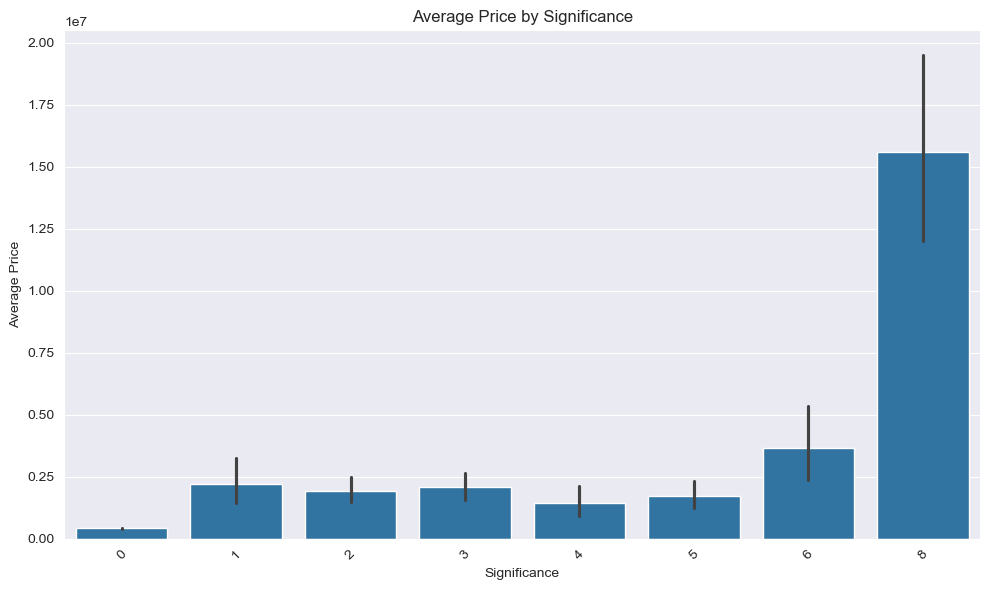

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='significance', y='price', estimator='mean')
plt.title('Average Price by Significance')
plt.xlabel('Significance')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Predikce

In [14]:
X = df.copy()
y = X["price"]
X.drop("price", axis=1, inplace=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

In [16]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=666)

In [17]:
print(f"Size train - X: {X_train.shape}, y: {y_train.shape}")
print(f"Size val - X: {X_val.shape}, y: {y_val.shape}")
print(f"Size test - X: {X_test.shape}, y: {y_test.shape}")

Size train - X: (41308, 6), y: (41308,)
Size val - X: (5163, 6), y: (5163,)
Size test - X: (5164, 6), y: (5164,)


## Nearesst Neighbours

In [20]:
X_train_new = X_train.copy()
X_train_new.drop("plate", axis=1, inplace=True)

In [22]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train_new, y_train)

KNeighborsRegressor(n_neighbors=10)

In [23]:
Xnew_val = X_val.drop("plate", axis=1)
predicted = neigh.predict(Xnew_val)
root_mean_squared_error(y_val, predicted)

2747050.0779242674